In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import wave
import math
import uuid
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from pydub import AudioSegment
import pickle

## Directory Notes:
- Clean Raw = No Audio Augmented Added
- Audio Augmented Raw = Added Augmented Audio

In [2]:
# Define raw audio dictionary
raw_audio_full = {}
raw_audio_augmented = {}

# Loop through directioris and label audio files
directories = ['cat', 'dog', 'infant_cry']
for directory in directories:
    path = '../data/infant_raw/' + directory
    for filename in os.listdir(path):
        if filename.endswith(".wav"):
            raw_audio_full[os.path.join(path, filename)] = directory

In [3]:
# Split the audio file to create second dataset
def split_audio(audio_path, num_parts=10):
    sound = AudioSegment.from_file(audio_path, format="wav")
    duration = len(sound)
    part_duration = duration // num_parts
    parts = [sound[i*part_duration:(i+1)*part_duration] for i in range(num_parts)]
    return parts

# Apply data augmentation to create augmented dataset
for audio_file, label in raw_audio_full.items():
    parts = split_audio(audio_file)
    for part in parts:
        raw_audio_augmented[part] = label


In [4]:
import numpy as np

# Define a fixed length for MFCC feature vectors
max_length = 100

# Extract MFCC Features and Chop audio
# Preemphasis filter for high frequency
def preemphasis_filter(signal, alpha=0.97):
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

# Frame the signal into 25 ms frame and 10 ms frame shift
def frame_signal(signal, frame_length, frame_stride):
    signal_length = len(signal)
    frame_step = int(frame_stride)
    frame_length = int(frame_length)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    return frames
    
# Apply Hamming Windows and Compute the power spectrum
def power_spectrum(frames, NFFT=512):
    frames *= np.hamming(frames.shape[1])
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))
    return pow_frames

# Apply Mel Filterbank
def mel_filterbank(spectrum, num_filters=40, sampling_rate=22050, n_fft=512):
    mel_filterbank = librosa.filters.mel(sr=sampling_rate, n_fft=n_fft, n_mels=num_filters)
    return np.dot(mel_filterbank, spectrum.T).T

# Compute MFCCS
def mfcc(signal, sampling_rate=22050, frame_length=512, frame_shift=256, num_mfcc=13, n_mels=40):
    emphasized_signal = preemphasis_filter(signal)
    framed_signal = frame_signal(emphasized_signal, frame_length, frame_shift)
    spectrum = power_spectrum(framed_signal)
    mel_spectrum = mel_filterbank(spectrum, num_filters=n_mels, sampling_rate=sampling_rate, n_fft=512)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrum), n_mfcc=num_mfcc, n_mels=n_mels)

    # Ensure the MFCCs have a fixed length
    if mfccs.shape[1] < max_length:
        mfccs_padded = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
    elif mfccs.shape[1] > max_length:
        mfccs_padded = mfccs[:, :max_length]
    else:
        mfccs_padded = mfccs
    
    return mfccs_padded.flatten()


In [5]:
# Feature Extraction: MFCC simplified
def extract_mfcc_augmented(audio_part, sigr=22050, n_mfcc=13, hop_length=None, n_fft=None):
    if hop_length is None:
        hop_length = int(0.010 * sigr)
    if n_fft is None:
        n_fft = int(0.025 * sigr)
    audio_part = np.array(audio_part.get_array_of_samples(), dtype=np.float32)
    mfccs = librosa.feature.mfcc(y=audio_part, sr=sigr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    return mfccs.T  # Transpose to have time steps as rows


In [6]:

# Extract MFCC Features and create DataFrame
X_full = []
y_full = []

for audio_file, label in raw_audio_full.items():
    signal, sr = librosa.load(audio_file, sr=None)
    mfcc_features_full = mfcc(signal, sampling_rate=sr)
    X_full.append(mfcc_features_full.flatten())
    y_full.append(label)

import pandas as pd

# Convert the features and labels to a DataFrame
df_full_audio = pd.DataFrame(X_full)
df_full_audio = df_full_audio.fillna(0)
df_full_audio['label'] = y_full  # Add the labels as a new column

# Save the DataFrame to a CSV file
df_full_audio.to_csv('infant_audio_augmented_full_audio_features.csv', index=False)

In [7]:
X_augmented = []
y_augmented = []

for audio_part, label in raw_audio_augmented.items():
    mfcc_features_augmented = extract_mfcc_augmented(audio_part)  # Replace with your simplified method function call
    X_augmented.append(mfcc_features_augmented.flatten())
    y_augmented.append(label)

df_augment_audio = pd.DataFrame(X_augmented)
df_augment_audio = df_augment_audio.fillna(0)
df_augment_audio['label'] = y_augmented  # Add the labels as a new column

# Save the DataFrame to a CSV file
df_full_audio.to_csv('infant_augmented_audio_chop_features.csv', index=False)

In [8]:
# Combine full and augmented datasets
X_combined = X_full + X_augmented
y_combined = y_full + y_augmented

# Create DataFrame from features
df_combined = pd.DataFrame(X_combined)
df_combined = df_combined.fillna(0)
df_combined['label'] = y_combined

# Save to CSV
df_combined.to_csv('infant_audio_augment_combined_audio_dataset.csv', index=False)


In [9]:
# Load combined dataset
df_combined = pd.read_csv('infant_audio_augment_combined_audio_dataset.csv')

# Preprocess data
label_encoder = LabelEncoder()
df_combined['label'] = label_encoder.fit_transform(df_combined['label'])
X = df_combined.drop('label', axis=1).values
y = df_combined['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define Models
models = {
    #'k-NN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='rbf', C=12, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=32, criterion='entropy', random_state=42),
    #'MLP': MLPClassifier(alpha=0.01, max_iter=1000, hidden_layer_sizes=(12,), solver='lbfgs', random_state=42)
}

In [11]:
# Train Models on Combined Data
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"{name} - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
    print(f"{name} Classification Report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

SVM - Accuracy: 0.9369747899159664, Precision: 0.9299275362318841, Recall: 0.9245344665238003, F1 Score: 0.9269637314257135
SVM Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       177
           1       0.90      0.86      0.88        96
           2       0.98      0.97      0.97       203

    accuracy                           0.94       476
   macro avg       0.93      0.92      0.93       476
weighted avg       0.94      0.94      0.94       476

Random Forest - Accuracy: 0.9474789915966386, Precision: 0.9394003954853676, Recall: 0.929084274952919, F1 Score: 0.9337672020684137
Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       177
           1       0.91      0.84      0.88        96
           2       0.99      1.00      0.99       203

    accuracy                           0.95       476
   macro avg       0.94 

SVM: Mean Accuracy: 0.60, Std Dev: 0.00
Random Forest: Mean Accuracy: 0.66, Std Dev: 0.00
Accuracy: 0.9265454545454546
Precision: 0.9315198897225941
Recall: 0.9265454545454546
F1 Score: 0.92629680919311
Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.98      0.86      0.92       352
     burping       1.00      0.90      0.95       264
  discomfort       0.94      0.90      0.92       594
      hungry       0.87      1.00      0.93      1012
       tired       0.96      0.88      0.92       528

    accuracy                           0.93      2750
   macro avg       0.95      0.91      0.93      2750
weighted avg       0.93      0.93      0.93      2750



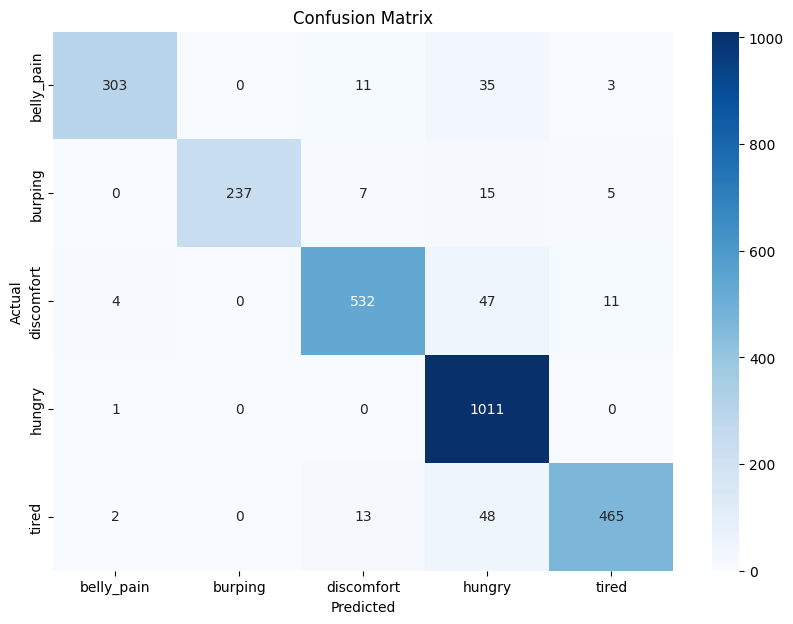

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
# Set up 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Run each algorithm 30 times
results = {name: [] for name in models}
for name, clf in models.items():
    for _ in range(30):
        scores = cross_val_score(clf, X, y, cv=kf)
        results[name].append(np.mean(scores))

# Calculate mean and standard deviation of accuracy scores
for name, scores in results.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"{name}: Mean Accuracy: {mean_score:.2f}, Std Dev: {std_score:.2f}")

# Load the trained model, scaler, and label encoder
trained_model_svm = load_pickle('models/audio_augmented_model/rf_model.pkl')
scaler = load_pickle('models/audio_augmented_model/scaler_rf.pkl')
label_encoder = load_pickle('models/audio_augmented_model/label_encoder_rf.pkl')

# Load combined dataset for evaluation
df_combined = pd.read_csv('audio_augment_combined_audio_dataset.csv')

# Preprocess the data
df_combined['label'] = label_encoder.transform(df_combined['label'])
X = df_combined.drop('label', axis=1).values
y = df_combined['label'].values

# Scale the data
X_scaled = scaler.transform(X)

# Predict using the trained model
y_pred = trained_model_svm.predict(X_scaled)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred, average='weighted'))
print("Recall:", recall_score(y, y_pred, average='weighted'))
print("F1 Score:", f1_score(y, y_pred, average='weighted'))
print("Classification Report:\n", classification_report(y, y_pred, target_names=label_encoder.classes_))

# Visualize the confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# IGNORE
import pickle
def save_pickle(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

In [13]:
# IGNORE
best_model = models['SVM']
save_pickle(best_model, 'models/infant/svm_model.pkl')
save_pickle(scaler, 'models/infant/scaler_svm.pkl')
save_pickle(label_encoder, 'models/infant/label_encoder_svm.pkl')

best_model = models['Random Forest']
save_pickle(best_model, 'models/infant/rf_model.pkl')
save_pickle(scaler, 'models/infant/scaler_rf.pkl')
save_pickle(label_encoder, 'models/infant/label_encoder_rf.pkl')

In [14]:
#IGNORE
# Function to load a model from a file
def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [14]:
# IGnore
# Load the trained model, scaler, and label encoder
trained_model_svm = load_pickle('models/audio_augmented_model/svm_model.pkl')
scaler = load_pickle('models/audio_augmented_model/scaler_rf.pkl')
label_encoder = load_pickle('models/audio_augmented_model/label_encoder_svm.pkl')


In [20]:
import pickle

# Save the best SVM model
best_svm_model = grid_svm.best_estimator_
with open('models/donateacry/best_clean_svm_model_new.pkl', 'wb') as f:
    pickle.dump(best_svm_model, f)

# Save the best Random Forest model
best_rf_model = grid_rf.best_estimator_
with open('models/donateacry/best_clean_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f)


## Good Testing Clean SVM and RF Model

Number of true labels: 217
Number of predicted labels: 217
True labels: {'dog', 'cat', 'infant_cry'}
Predicted labels: {'dog', 'cat', 'infant_cry'}


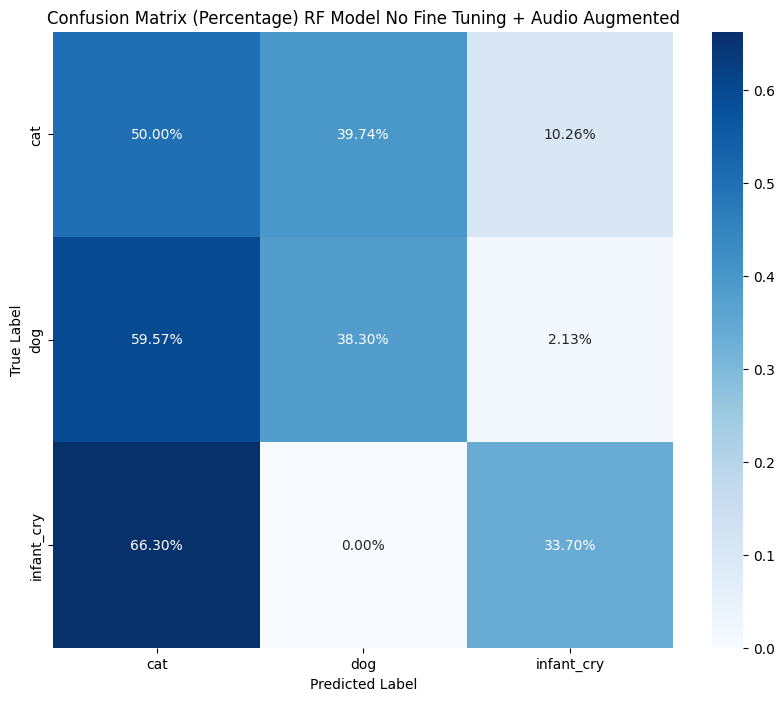

Label: cat, Total Count: 78, Correctly Predicted: 39
Label: dog, Total Count: 47, Correctly Predicted: 18
Label: infant_cry, Total Count: 92, Correctly Predicted: 31

Classification Report:
              precision    recall  f1-score   support

         cat       0.30      0.50      0.38        78
         dog       0.37      0.38      0.38        47
  infant_cry       0.78      0.34      0.47        92

    accuracy                           0.41       217
   macro avg       0.48      0.41      0.41       217
weighted avg       0.52      0.41      0.42       217

Predicted label for 435806317_25534324009486266_6473560724221715299_n.wav: cat


In [18]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from collections import Counter

# Function to load a model or other objects from a file
def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Load the trained model, scaler, and label encoder
trained_model = load_pickle('models/infant/rf_model.pkl')
scaler = load_pickle('models/infant/scaler_rf.pkl')
label_encoder = load_pickle('models/infant/label_encoder_rf.pkl')

# Define the fixed length for MFCC feature vectors
fixed_length = 1677  # Ensure this matches the length used during training

# Define the class labels
class_labels = label_encoder.classes_

def preprocess_audio(audio_path, fixed_length):
    try:
        audiofile, sr = librosa.load(audio_path, sr=None)
        mfcc_features = librosa.feature.mfcc(y=audiofile, sr=sr, n_mfcc=13)
        mfcc_features_flat = mfcc_features.flatten()
        if len(mfcc_features_flat) < fixed_length:
            mfcc_features_flat = np.pad(mfcc_features_flat, (0, fixed_length - len(mfcc_features_flat)), 'constant')
        elif len(mfcc_features_flat) > fixed_length:
            mfcc_features_flat = mfcc_features_flat[:fixed_length]
        mfcc_features_flat = scaler.transform([mfcc_features_flat])
        return mfcc_features_flat
    except Exception as e:
        print(f"Error processing audio file {audio_path}: {e}")
        return None

# Predict on new audio snippets and collect true and predicted labels
folder_path = '../data/infant_raw/'
y_true = []
y_pred = []
results = []

for folder_name in os.listdir(folder_path):
    folder_dir = os.path.join(folder_path, folder_name)
    for filename in os.listdir(folder_dir):
        if filename.endswith(".wav"):
            audio_path = os.path.join(folder_dir, filename)
            preprocessed_audio = preprocess_audio(audio_path, fixed_length)
            if preprocessed_audio is not None:
                prediction = trained_model.predict(preprocessed_audio)
                predicted_label = label_encoder.inverse_transform(prediction)[0]
                y_true.append(folder_name)
                y_pred.append(predicted_label)
                results.append(f"Original: {folder_name} Predicted: {predicted_label}")

# Debugging print statements
print(f"Number of true labels: {len(y_true)}")
print(f"Number of predicted labels: {len(y_pred)}")
print(f"True labels: {set(y_true)}")
print(f"Predicted labels: {set(y_pred)}")

if len(y_true) == 0 or len(y_pred) == 0:
    print("No predictions made. Check the data processing pipeline.")
else:
    label_counts = Counter(y_true)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)

    # Normalize the confusion matrix to show percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix (Percentage) RF Model No Fine Tuning + Audio Augmented')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('RF Model No Fine Tuning + Audio Augmented.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Extract the correct predictions (diagonal elements)
    correct_predictions = np.diag(cm)

    # Display the number of items and correctly predicted items per label
    for i, label in enumerate(class_labels):
        print(f"Label: {label}, Total Count: {label_counts[label]}, Correctly Predicted: {correct_predictions[i]}")

    # Generate and display the classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

# Test function for a single audio file
def test_single_audio(audio_path):
    preprocessed_audio = preprocess_audio(audio_path, fixed_length)
    if preprocessed_audio is not None:
        prediction = trained_model.predict(preprocessed_audio)
        predicted_label = label_encoder.inverse_transform(prediction)[0]
        print(f"Predicted label for {os.path.basename(audio_path)}: {predicted_label}")
    else:
        print("Error processing audio.")

# Test a single audio file
single_audio_path = '../data/indiv_test/435806317_25534324009486266_6473560724221715299_n.wav'
test_single_audio(single_audio_path)


In [1]:
!jupyter nbconvert --to script babyCryFinal.ipynb


[NbConvertApp] Converting notebook babyCryFinal.ipynb to script
[NbConvertApp] Writing 20578 bytes to babyCryFinal.py
